## Code for LectinOracle

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import sys, os
from collections import Counter
import itertools
from itertools import compress
import operator
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import re
import copy
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from functools import reduce
from scipy.stats import wilcoxon
!pip install torch==1.8.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
import torch
from torch import nn
import torch.nn.functional as F

fp = 'data/'

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 763.5 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

!pip install glycowork
import glycowork

In [ ]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import TopKPooling, GraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from glycowork.ml.processing import dataset_to_graphs
from glycowork.motif.processing import get_lib, min_process_glycans
from glycowork.motif.graph import glycan_to_graph, graph_to_string, glycan_to_nxGraph, try_string_conversion, subgraph_isomorphism
from glycowork.motif.annotate import annotate_dataset
from glycowork.motif.analysis import get_pvals_motifs
from glycowork.glycan_data.loader import unwrap, motif_list
from glycowork.network.biosynthesis import safe_max, create_neighbors

# Data Loading

In [ ]:
all_meta = pd.read_csv(fp+'all_meta.csv')
train = pd.read_csv(fp+'all_arrays.csv')
data_min = min([k for k in train.iloc[:,:-1].min() if np.isfinite(k)])
data_max = np.nanmax(train.iloc[:,:-1].values)
train, val = train_test_split(train, test_size = 0.1, random_state = 1, shuffle = True)
with open(fp+'stored_protein_embeddings.pkl', 'rb') as file:
  old_dic = pickle.load(file)

# Legacy: Getting ESM-1b representations for new lectins

In [ ]:
##LEGACY - for getting new ESM-1b representations if wanting to apply LectinOracle to new proteins
## Preparing protein representations via ESM-1b
#!pip install fair-esm
#import torch
#import esm

## Load ESM-1b model
#model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
#batch_converter = alphabet.get_batch_converter()

In [ ]:
##LEGACY - for getting new ESM-1b representations if wanting to apply LectinOracle to new proteins
## Get sequences for which we do not have a stored representation yet
#with open(fp+'stored_protein_embeddings.pkl', 'rb') as file:
#  old_dic = pickle.load(file)
#new_seqs = [k for k in list(set(train.target.values.tolist()+val.target.values.tolist())) if k not in list(old_dic.keys())]
#new_seqs = [k for k in all_meta.sequence.values.tolist() if k not in list(old_dic.keys())]
#new_seqs = list(set(new_seqs))
#new_seqs = [k for k in new_seqs if isinstance(k, str)]
#len(new_seqs)

In [ ]:
##LEGACY - for getting new ESM-1b representations if wanting to apply LectinOracle to new proteins
## Get representation for protein sequences in new_seqs
#data_list = []
#for k in range(0,len(new_seqs)):
#  if len(new_seqs[k])<1000:
#    data_list.append(('protein'+str(k), new_seqs[k][:np.min([len(new_seqs[k]),1000])]))
#  else:
#    data_list.append(('protein'+str(k), new_seqs[k][:1000]))
#batch_labels, batch_strs, batch_tokens = batch_converter(data_list)
#with torch.no_grad():
#    results = model(batch_tokens, repr_layers=[33], return_contacts=False)
#token_representations = results["representations"][33]
#sequence_representations = []
#for i, (_, seq) in enumerate(data_list):
#    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

In [ ]:
##LEGACY - for getting new ESM-1b representations if wanting to apply LectinOracle to new proteins
## Update representation dictionary and save
#prot_dic =  {new_seqs[k]:sequence_representations[k].tolist() for k in range(len(sequence_representations))}
#prot_dic = {**old_dic, **prot_dic}
#with open(fp+'stored_protein_embeddings.pkl', 'wb') as file:
#  pickle.dump(prot_dic, file)

# Data Preparation

In [ ]:
#retrieve representations for protein sequences
train.target = [old_dic[k] if k in list(old_dic.keys()) else np.nan for k in train.target.values.tolist()]
train = train[train.target.notna()].reset_index(drop = True)
val.target = [old_dic[k] if k in list(old_dic.keys()) else np.nan for k in val.target.values.tolist()]
val = val[val.target.notna()].reset_index(drop = True)
train

In [ ]:
#converts data into format (protein, glycan, binding)
def generate_pair_data(df):
  """creates 3-tuples of lectin, glycan, and the corresponding binding value"""
  out = []
  for k in range(len(df)):
    for j in range(df.shape[1]-1):
      if ~np.isnan(df.iloc[k,j]) and np.isfinite(df.iloc[k,j]):
        out.append((df.loc[k,'target'], df.columns.values.tolist()[j], df.iloc[k,j]))
  return out

train = generate_pair_data(train)
val = generate_pair_data(val)
len(train+val)

In [ ]:
#split into train/validation sets
train2 = pd.DataFrame(train, columns = ['seq', 'glycan', 'match'])
val2 = pd.DataFrame(val, columns = ['seq', 'glycan', 'match'])
#the extension of lib was done for unrelated downstream analyses and is needed to use the trained LectinOracle file but does not need to be there if you train a new LectinOracle model
lib = get_lib(list(set(train2.glycan.values.tolist()+val2.glycan.values.tolist()))) + ['GlcNAcOS', 'GalOS', 'HexNAc']
X_train = list(zip(train2.seq.values.tolist(), [glycan_to_graph(k, libr = lib) for k in train2.glycan.values.tolist()]))
y_train = train2.match.values.tolist()
X_val = list(zip(val2.seq.values.tolist(), [glycan_to_graph(k, libr = lib) for k in val2.glycan.values.tolist()]))
y_val = val2.match.values.tolist()

In [ ]:
#make dataloaders for deep learning models
trainset = [Data(x = torch.tensor(k[0][1][0], dtype = torch.long), y = torch.tensor(k[1], dtype = torch.float),
                 edge_index = torch.tensor([k[0][1][1][0], k[0][1][1][1]], dtype = torch.long)) for k in list(zip(X_train, y_train))]
for k in range(len(trainset)):
  trainset[k].train_idx = torch.tensor(X_train[k][0], dtype = torch.float)
valset = [Data(x = torch.tensor(k[0][1][0], dtype = torch.long), y = torch.tensor(k[1], dtype = torch.float),
                 edge_index = torch.tensor([k[0][1][1][0], k[0][1][1][1]], dtype = torch.long)) for k in list(zip(X_val, y_val))]
for k in range(len(valset)):
  valset[k].train_idx = torch.tensor(X_val[k][0], dtype=torch.float)

train_loader = DataLoader(trainset, batch_size = 128, shuffle = True)
val_loader = DataLoader(valset, batch_size = 128, shuffle = False)
dataloaders = {'train':train_loader, 'val':val_loader}

# Model Preparation

In [ ]:
#defining LectinOracle

def sigmoid_range(x, low, high):
    "Sigmoid function with range `(low, high)`"
    return torch.sigmoid(x) * (high - low) + low

class SigmoidRange(nn.Module):
    "Sigmoid module with range `(low, x_max)`"
    def __init__(self, low, high):
      super(SigmoidRange, self).__init__()
      self.low, self.high = low,high
    def forward(self, x): return sigmoid_range(x, self.low, self.high)

class LectinOracle(nn.Module):
  def __init__(self, input_size_glyco, hidden_size, num_classes, data_min,
               data_max, input_size_prot = 1280, n_layers = 1):
    super(LectinOracle,self).__init__()
    self.input_size_prot = input_size_prot
    self.input_size_glyco = input_size_glyco
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.conv1 = GraphConv(self.hidden_size, self.hidden_size)
    self.pool1 = TopKPooling(self.hidden_size, ratio = 0.8)
    self.conv2 = GraphConv(self.hidden_size, self.hidden_size)
    self.pool2 = TopKPooling(self.hidden_size, ratio = 0.8)
    self.conv3 = GraphConv(self.hidden_size, self.hidden_size)
    self.pool3 = TopKPooling(self.hidden_size, ratio = 0.8)
    self.item_embedding = torch.nn.Embedding(num_embeddings = self.input_size_glyco, embedding_dim = self.hidden_size)
    self.prot_encoder1 = nn.Linear(self.input_size_prot, 400)
    self.prot_encoder2 = nn.Linear(400, 128)
    self.glyco_encoder = nn.Embedding(self.input_size_glyco, self.hidden_size, padding_idx = self.input_size_glyco - 1)
    self.dp1 = nn.Dropout(0.5)
    self.dp_prot1 = nn.Dropout(0.2)
    self.dp_prot2 = nn.Dropout(0.1)
    self.fc1 = nn.Linear(128+2*self.hidden_size, int(np.round(self.hidden_size/2)))
    self.fc2 = nn.Linear(int(np.round(self.hidden_size/2)), num_classes)
    self.bn1 = nn.BatchNorm1d(int(np.round(self.hidden_size/2)))
    self.bn_prot1 = nn.BatchNorm1d(400)
    self.bn_prot2 = nn.BatchNorm1d(128)
    self.act1 = torch.nn.LeakyReLU()
    self.act_prot1 = torch.nn.LeakyReLU()
    self.act_prot2 = torch.nn.LeakyReLU()
    self.sigmoid = SigmoidRange(data_min, data_max)
    
    
  def forward(self, prot, nodes, edge_index, batch, inference = False):
    embedded_prot = self.bn_prot1(self.act_prot1(self.dp_prot1(self.prot_encoder1(prot))))
    embedded_prot = self.bn_prot2(self.act_prot2(self.dp_prot2(self.prot_encoder2(embedded_prot))))

    x = self.item_embedding(nodes)
    x = x.squeeze(1) 

    x = F.leaky_relu(self.conv1(x, edge_index))

    x, edge_index, _, batch, _, _= self.pool1(x, edge_index, None, batch)
    x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

    x = F.leaky_relu(self.conv2(x, edge_index))
     
    x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
    x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

    x = F.leaky_relu(self.conv3(x, edge_index))
        
    x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
    x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

    x = x1 + x2 + x3

    h_n = torch.cat((embedded_prot, x), 1)
    
    h_n = self.bn1(self.act1(self.fc1(h_n)))

    #1
    x1 = self.fc2(self.dp1(h_n))
    #2
    x2 = self.fc2(self.dp1(h_n))
    #3
    x3 = self.fc2(self.dp1(h_n))
    #4
    x4 = self.fc2(self.dp1(h_n))
    #5
    x5 = self.fc2(self.dp1(h_n))
    #6
    x6 = self.fc2(self.dp1(h_n))
    #7
    x7 = self.fc2(self.dp1(h_n))
    #8
    x8 = self.fc2(self.dp1(h_n))
    
    out =  self.sigmoid(torch.mean(torch.stack([x1, x2, x3, x4, x5, x6, x7, x8]), dim = 0))
    
    if inference:
      return out, embedded_prot, x
    else:
      return out

In [ ]:
#training loop function

def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  """training loop for LectinOracle"""
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_mse = 100.0
  val_losses = []
  val_mse = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_mse = []
      running_mae = []
      running_max = []
      for data in dataloaders[phase]:
        x, y, edge_index, prot, batch = data.x, data.y, data.edge_index, data.train_idx, data.batch
        x = x.cuda()
        y = y.cuda()
        prot = prot.view(max(batch)+1, -1).cuda()
        edge_index = edge_index.cuda()
        batch = batch.cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred = model(prot, x, edge_index, batch)
          loss = criterion(pred, y.view(-1,1))
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_mse.append(mean_squared_error(y.detach().cpu().numpy(), pred.detach().cpu().numpy()))
        running_mae.append(mean_absolute_error(y.detach().cpu().numpy(), pred.detach().cpu().numpy()))
        running_max.append(max_error(y.detach().cpu().numpy(), pred.detach().cpu().numpy()))
        
      epoch_loss = np.mean(running_loss)
      epoch_mse = np.mean(running_mse)
      epoch_mae = np.mean(running_mae)
      epoch_max = np.mean(running_max)
      print('{} Loss: {:.4f} MSE: {:.4f} MAE: {:.4f} MaxE: {:.4f}'.format(
          phase, epoch_loss, epoch_mse, epoch_mae,
          epoch_max))
      
      if phase == 'val' and epoch_mse <= best_mse:
        best_mse = epoch_mse
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_mse.append(epoch_mse)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val MSE: {:4f}'.format(best_mse))
  model.load_state_dict(best_model_wts)

  ## plot loss & MSE over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of Model')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'], loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_mse)
  plt.ylabel('Validation MSE')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation MSE'], loc = 'best')
  return model

In [ ]:
#early stopping function if training stalls
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience = 7, verbose = False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

# LectinOracle

In [ ]:
#specifiying the model and training it

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)

## instantiating the model itself, initializing it and putting it on the GPU             
LeOr = LectinOracle(input_size_prot = 1280, input_size_glyco = len(lib) + 1, hidden_size = 128,
          num_classes = 1, data_min = data_min, data_max = data_max)
LeOr.apply(init_weights)
LeOr.cuda()

early_stopping = EarlyStopping(patience = 20, verbose = True)
optimizer_ft = torch.optim.Adam(LeOr.parameters(), lr = 0.0005, weight_decay = 0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 80)
criterion = nn.MSELoss().cuda()
#model_ft = train_model(LeOr, criterion, optimizer_ft, scheduler,
#                   num_epochs = 100)

# Get Lectin Binding Specificity

In [ ]:
#loading a trained LectinOracle model
model_ft = LectinOracle(input_size_prot = 1280, input_size_glyco = len(lib)+1, hidden_size = 128,
          num_classes = 1, data_min = data_min, data_max = data_max)
model_ft.load_state_dict(torch.load(fp+'LectinOracle_565.pt'))
model_ft = model_ft.cuda()

In [ ]:
#functions to get predicted lectin binding with a trained LectinOracle model

df_corr = pd.read_csv(fp+'background_correction_for_565.csv')

def get_pred(prot, glycan, model_ft = model_ft, prot_dic = old_dic, batch_size = 128):
  try:
    repr = prot_dic[prot]
  except:
    print('new protein, no stored embedding')
  ggraph = glycan_to_graph(glycan, libr = lib)
  graph_data = [Data(x = torch.tensor(ggraph[0], dtype = torch.long), y = torch.tensor(0.99, dtype = torch.float),
                    edge_index = torch.tensor([ggraph[1][0], ggraph[1][1]], dtype = torch.long))]*batch_size
  for k in range(len(graph_data)):
    graph_data[k].train_idx = torch.tensor(repr, dtype = torch.float)
  train_loader = DataLoader(graph_data, batch_size = batch_size, shuffle = False)
  model_ft = model_ft.eval()
  res = []
  for k in train_loader:
    x, y, edge_index, prot, batch = k.x, k.y, k.edge_index, k.train_idx, k.batch
    x = x.cuda()
    y = y.cuda()
    prot = prot.view(max(batch)+1, -1).cuda()
    edge_index = edge_index.cuda()
    batch = batch.cuda()
    pred = model_ft(prot, x, edge_index, batch)
    res.append(pred)
  res = [res[k].detach().cpu().numpy() for k in range(len(res))][0][0].tolist()[0]
  return res

def get_multi_pred(prot, glycans, model_ft = model_ft, prot_dic = old_dic, batch_size = 128,
                   background_correction = False, correction_df = df_corr):
  try:
    repr = prot_dic[prot]
  except:
    print('new protein, no stored embedding')
  ggraph = [glycan_to_graph(k, libr = lib) for k in glycans]
  graph_data = [Data(x = torch.tensor(ggraph[k][0], dtype = torch.long), y = torch.tensor(0.99, dtype = torch.float),
                    edge_index = torch.tensor([ggraph[k][1][0], ggraph[k][1][1]], dtype = torch.long)) for k in range(len(ggraph))]
  for k in range(len(graph_data)):
    graph_data[k].train_idx = torch.tensor(repr, dtype=torch.float)
  train_loader = DataLoader(graph_data, batch_size = batch_size, shuffle = False)
  model_ft = model_ft.eval()
  res = []
  for k in train_loader:
    x, y, edge_index, prot, batch = k.x, k.y, k.edge_index, k.train_idx, k.batch
    x = x.cuda()
    y = y.cuda()
    prot = prot.view(max(batch)+1, -1).cuda()
    edge_index = edge_index.cuda()
    batch = batch.cuda()
    pred = model_ft(prot, x, edge_index, batch)
    res.append(pred)
  res = unwrap([res[k].detach().cpu().numpy() for k in range(len(res))])
  res = [k.tolist()[0] for k in res]
  if background_correction:
    correction_df = pd.Series(correction_df.pred.values, index = correction_df.motif).to_dict()
    bg_res = [correction_df[j] if j in list(correction_df.keys()) else 0 for j in glycans]
    if 0 in bg_res:
      print("Warning: not all glycans are in the correction_df; consider adding their background to correction_df")
    res = [a_i - b_i for a_i, b_i in zip(res, bg_res)]
  return res

In [ ]:
with open(fp+'glycan_trisaccharide_motifs.pkl', 'rb') as file:
  old_motifs = pickle.load(file)
trisaccharides = list(set(unwrap(list(old_motifs.values()))))

def get_motif_predictions(protein, model = model_ft, more_motifs = False, prot_dic = old_dic,
                          trisaccharides = False, trisaccharide_list = trisaccharides, background_correction = False,
                          correction_df = df_corr, batch_size = 128, add_in_full = False, sorted = True):
  glycans = list(set(train2.glycan.values.tolist() + val2.glycan.values.tolist()))
  glycan_motifs = annotate_dataset(glycans, libr = lib, feature_set = ['exhaustive'], condense = True)
  glycan_motifs = glycan_motifs.columns.values.tolist()
  glycan_motifs = [k for k in glycan_motifs if '(' in k]
  if more_motifs:
    glycan_motifs = [glycan_motifs]
    forbidden_list = ['2(', '3(', '4(', '6(', ')(', 'b1-4GlcNAc']
    for k in glycans:
      ggraph = glycan_to_nxGraph(k, libr = lib)
      ggraph_nb = create_neighbors(ggraph, libr = lib)
      g_nb = [try_string_conversion(j, libr = lib) for j in ggraph_nb]
      g_nb = [j for j in g_nb if j is not None]
      g_nb = [j if j[0] != '[' else j.replace('[','',1).replace(']','',1) for j in g_nb]
      g_nb = [j for j in g_nb if j[0] != '(']
      g_nb = [j for j in g_nb if not any([m in j for m in forbidden_list])]
      glycan_motifs.append(g_nb)
    glycan_motifs = list(set(unwrap(glycan_motifs)))
  if trisaccharides:
    glycan_motifs = glycan_motifs + trisaccharide_list
  if add_in_full:
    glycan_motifs = glycan_motifs + glycans
  preds = get_multi_pred(protein, glycan_motifs, model, prot_dic = prot_dic,
                         batch_size = batch_size)
  df_pred = pd.DataFrame(glycan_motifs, columns = ['motif'])
  df_pred['pred'] = preds
  if background_correction:
    correction_df = pd.Series(correction_df.pred.values, index = correction_df.motif).to_dict()
    for j in df_pred.motif.values.tolist():
      motif_idx = df_pred.motif.values.tolist().index(j)
      df_pred.at[motif_idx, 'pred'] = df_pred.iloc[motif_idx, 1] - correction_df[j]
  if sorted:
    df_pred.sort_values('pred', ascending=True, inplace=True)
  return df_pred

ConA = 'ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVDKRLSAVVSYPNADSATVSYDVDLDNVLPEWVRVGLSASTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGTDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFEATFTFLIKSPDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN'
cona_predictions = get_motif_predictions(ConA, trisaccharides = True, background_correction = True, add_in_full = True)

In [ ]:
SNA = all_meta[all_meta.name=='SNA'].sequence.values.tolist()[0]
SNA_pred = get_motif_predictions(SNA, more_motifs = True, trisaccharides = True, background_correction = True)
SNA_pred

MRLVAKLLYLAVLAICGLGIHGALTHPRVTPPVYPSVSFNLTGADTYEPFLRALQEKVILGNHTAFDLPVLNPESQVSDSNRFVLVPLTNPSGDTVTLAIDVVNLYVVAFSSNGKSYFFSGSTAVQRDNLFVDTTQEELNFTGNYTSLERQVGFGRVYIPLGPKSLDQAISSLRTYTLTAGDTKPLARGLLVVIQMVSEAARFRYIELRIRTSITDASEFTPDLLMLSMENNWSSMSSEIQQAQPGGIFAGVVQLRDERNNSIEVTNFRRLFELTYIAVLLYGCAPVTSSSYSNNAIDAQIIKMPVFRGGEYEKVCSVVEVTRRISGWDGLCVDVRYGHYIDGNPVQLRPCGNECNQLWTFRTDGTIRWLGKCLTASSSVMIYDCNTVPPEATKWVVSIDGTITNPHSGLVLTAPQAAEGTALSLENNIHAARQGWTVGDVEPLVTFIVGYKQMCLRENGENNFVWLEDCVLNRVQQEWALYGDGTIRVNSNRSLCVTSEDHEPSDLIVILKCEGSGNQRWVFNTNGTISNPNAKLLMDVAQRDVSLRKIILYRPTGNPNQQWITTTHPA


,motif,pred
3,GlcNAc(a1-4)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcN...,-1.015785
130,GlcNAc(a1-4)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)[Fuc...,-0.967623
1317,GalNAc6S(b1-4)GlcA(b1-3)GalNAc6S,-0.885204
353,GalNAc4S(b1-4)GlcA(b1-3)GalNAc4S(b1-4)GlcA(b1-...,-0.874227
939,Gal(b1-4)[Fuc(a1-3)]GlcNAc6S(b1-3)Gal6S(b1-3)G...,-0.865859
...,...,...
203,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc,3.899837
104,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcN...,3.966139
1048,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)[Fuc...,4.067162
337,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,4.376966


In [ ]:
def test_motif_enrichment(df_pred, motif):
  """testing for significant enrichment of motifs in glycans predicted to be bound"""
  df_pred = df_pred.sort_values(by = 'pred', ascending = False).reset_index(drop = True)
  if motif[-1] == ')':
    rank_order = [k for k in range(len(df_pred)) if motif in df_pred.motif.values.tolist()[k]]
  else:
    rank_order = [k for k in range(len(df_pred)) if motif in df_pred.motif.values.tolist()[k]]
    #rank_order = [k for k in range(len(df_pred)) if df_pred.motif.values.tolist()[k].startswith(motif)]
    #rank_order = [k for k in range(len(df_pred)) if subgraph_isomorphism(df_pred.motif.values.tolist()[k], motif, libr = lib)]
  bg = random.sample(list(range(len(df_pred))), len(rank_order))
  print(wilcoxon(rank_order, bg, alternative = 'less'))

# Protein Space Plots

In [ ]:
#get protein representations from trained LectinOracle model

def get_multi_pred_prot(prots, glycan, model_ft, mode = 'rep', prot_dic = old_dic, batch_size = 128):
  try:
    repr = [prot_dic[k] for k in prots]
  except:
    print('new protein, no stored embedding')
  glycans = [glycan]*len(prots)
  ggraph = [glycan_to_graph(k, libr = lib) for k in glycans]
  graph_data = [Data(x = torch.tensor(ggraph[k][0], dtype = torch.long), y = torch.tensor(0.99, dtype = torch.float),
                    edge_index = torch.tensor([ggraph[k][1][0], ggraph[k][1][1]], dtype = torch.long)) for k in range(len(ggraph))]
  for k in range(len(graph_data)):
    graph_data[k].train_idx = torch.tensor(repr[k], dtype = torch.float)
  train_loader = DataLoader(graph_data, batch_size = batch_size, shuffle = False)
  model_ft = model_ft.eval()
  res = []
  for k in train_loader:
    x, y, edge_index, prot, batch = k.x, k.y, k.edge_index, k.train_idx, k.batch
    x = x.cuda()
    y = y.cuda()
    prot = prot.view(max(batch)+1, -1).cuda()
    edge_index = edge_index.cuda()
    batch = batch.cuda()
    pred, rep_prot, rep_glyc = model_ft(prot, x, edge_index, batch, inference = True)
    if mode == 'rep':
      res.append(rep_prot)
    else:
      res.append(pred)
  res = unwrap([res[k].detach().cpu().numpy() for k in range(len(res))])
  return {prots[k]:res[k] for k in range(len(prots))}

prot_specs = [get_motif_predictions(k, more_motifs = False, trisaccharides = False, background_correction = True) for k in list(old_dic.keys())]
prot_specs_freq = [k if prot_specs.count(k) > 20 else 'misc' for k in prot_specs]

In [ ]:
#getting learned protein represenations from LectinOracle
prot_reps = get_multi_pred_prot(list(old_dic.keys()), 'Man(b1-4)GlcNAc(b1-4)GlcNAc', model_ft)
df_rep = pd.DataFrame(prot_reps)
df_rep = df_rep.T
tsne_emb = TSNE(random_state = 42).fit_transform(df_rep)

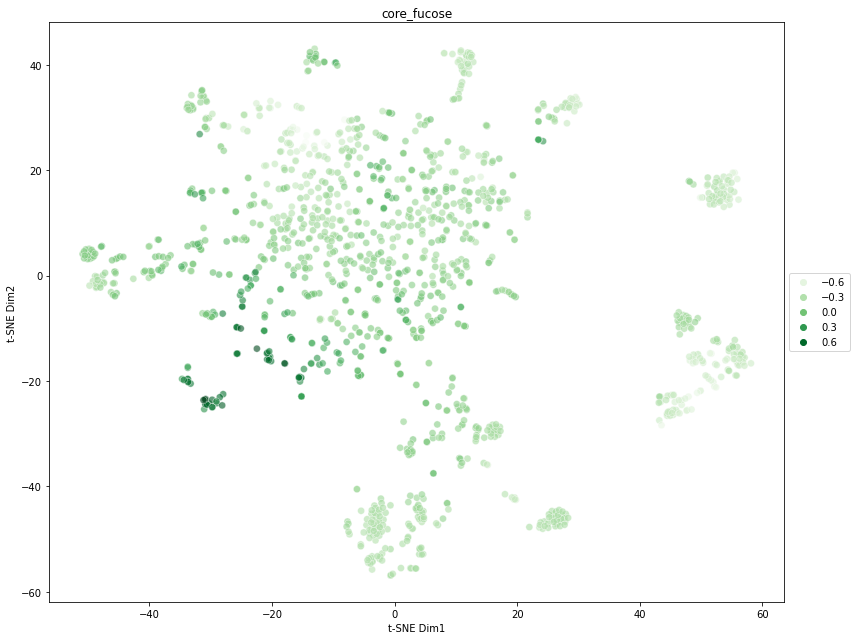

In [ ]:
#motif_pred_dict is not in data folder so this won't run but you can just predict binding to core fucose for all lectins and get a list of values to color this plot
motif = 'core_fucose'
plt.figure(figsize = (12, 9))
sns.scatterplot(x = tsne_emb[:,0], y = tsne_emb[:,1], s = 50, alpha = 0.6,
                hue = motif_pred_dict[motif], palette = 'Greens')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title(motif)
plt.tight_layout()

In [ ]:
#getting protein representations from ESM-1b (based on sequence similarity)
pre_preds = list(old_dic.values())
df_pre = pd.DataFrame(pre_preds)
tsne_emb_pre = TSNE(random_state = 42).fit_transform(df_pre)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


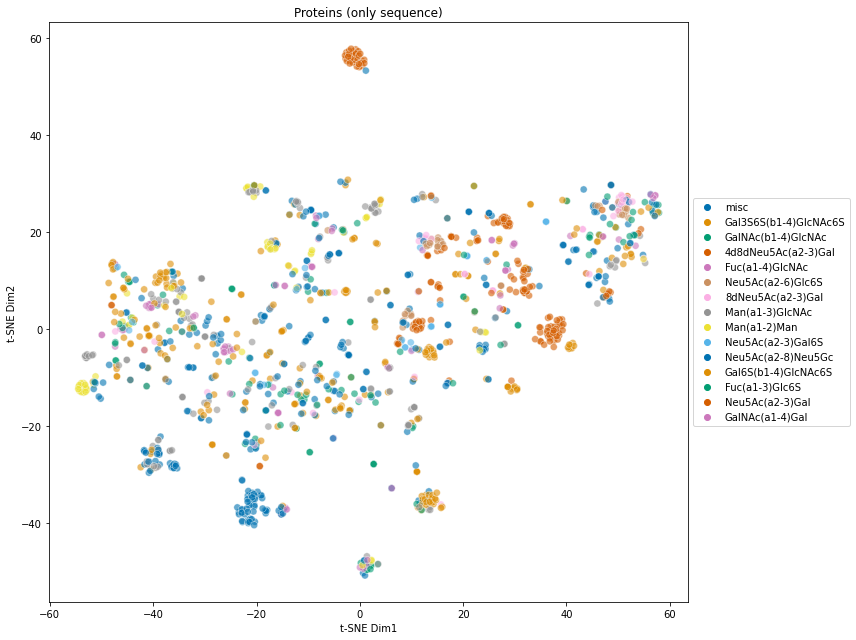

In [ ]:
plt.figure(figsize = (12, 9))
sns.scatterplot(tsne_emb_pre[:,0], tsne_emb_pre[:,1], s = 50, alpha = 0.6,
                hue = prot_specs_freq, palette = 'colorblind')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Proteins (only sequence)')
plt.tight_layout()

# Vaginal Microbiome Lectome

In [ ]:
##data from https://www.nature.com/articles/s41522-021-00220-9
#vm_lec = pd.read_csv(fp+'vaginal_microbiome_lectins.csv')
#with open(fp+'vaginal_microbiome_lectins_stored_protein_embeddings.pkl', 'rb') as file:
#  vm_dic = pickle.load(file)
#prot_specs = [get_motif_predictions(k, more_motifs=False, prot_dic = vm_dic, background_correction=True).motif.values.tolist()[-1] for k in list(vm_dic.keys())]

In [ ]:
lectin_class = [vm_lec.Lectin_class.values.tolist()[vm_lec.Sequence.values.tolist().index(k)] \
                if k in vm_lec.Sequence.values.tolist() else np.nan for k in list(vm_dic.keys())]
lectin_class_freq = [k if lectin_class.count(k)>5 else 'misc' for k in lectin_class]
bac_type = [vm_lec.Bac_Type.values.tolist()[vm_lec.Sequence.values.tolist().index(k)] \
                if k in vm_lec.Sequence.values.tolist() else np.nan for k in list(vm_dic.keys())]

In [ ]:
def get_binding_repertoire(strain, df = vm_lec, prot_dic = vm_dic, thresh = 0, more_motifs = False):
  lectins = df[df.Species_and_strain == strain].Sequence.values.tolist()
  motif_pool = []
  for k in lectins:
    df_motif = get_motif_predictions(k, more_motifs = more_motifs, trisaccharides = True,
                                     prot_dic = prot_dic, background_correction = True)
    motif_pool.append(df_motif)
  return motif_pool

#bp_ecoli_UMB0731 = get_binding_repertoire('Escherichia_coli_UMB0731')

In [ ]:
vm_lec2 = vm_lec[~vm_lec.Lectin_class.isin(['LysM-like', 'CBM50'])].reset_index(drop = True)
only_lec = vm_lec2[vm_lec2.Type == 'LEC'].reset_index(drop = True)

(1551, 8)
(1194, 8)


In [ ]:
species_list = list(sorted(list(set(vm_lec.Species_and_strain.values.tolist()))))
species_repertoires = {species:get_binding_repertoire(species, df = only_lec, thresh = 0.0, more_motifs = True) for species in species_list}
species_repertoires2 = {k:(pd.concat(species_repertoires[k], axis = 0).reset_index(drop = True) if len(species_repertoires[k])>0 else pd.DataFrame(columns = ['motif', 'pred'])) for k in species_list}
species_repertoires_0 = [len(list(set(species_repertoires2[k][species_repertoires2[k].pred>0].motif.values.tolist()))) for k in species_list]

In [ ]:
#finding enriched motifs in pathobionts & commensals
comm = only_lec[only_lec['Bac_Type'] == 'Commensal'].reset_index(drop = True)
comm_preds = [get_motif_predictions(k, trisaccharides = True, prot_dic = vm_dic,
                                     background_correction = True, add_in_full = True, sorted = False) for k in comm.Sequence.values.tolist()]
temp = pd.concat([pd.Series(k.pred.values.tolist()) for k in comm_preds], axis = 1).T
temp.columns = comm_preds[0].motif.values.tolist()
lib2 = list(set(lib + ['GalNAc6S', 'GlcN2S6S', 'D-IdoA', 'NeuNAc', 'Kdo', 'a2-4', 'GalA', 'Araf', 'GalN', 'Fuc4S',
                      'L-GulA', 'ManA']))

comm_pvals = get_pvals_motifs(temp, glycan_col_name = 'motif', label_col_name = 'pred', thresh = 0, feature_set = ['known', 'exhaustive'],
                               multiple_samples = True, libr = lib2)

In [ ]:
patho = only_lec[only_lec['Bac_Type'] == 'Pathobiont'].reset_index(drop = True)
patho_preds = [get_motif_predictions(k, trisaccharides = True, prot_dic = vm_dic,
                                     background_correction = True, add_in_full = True, sorted = False) for k in patho.Sequence.values.tolist()]
temp2 = pd.concat([pd.Series(k.pred.values.tolist()) for k in patho_preds], axis = 1).T
temp2.columns = patho_preds[0].motif.values.tolist()
patho_pvals = get_pvals_motifs(temp2, glycan_col_name = 'motif', label_col_name = 'pred', thresh = 0, feature_set = ['exhaustive', 'known'],
                               multiple_samples = True, libr = lib2)

In [ ]:
comms = {comm_pvals.motif.values.tolist()[k]:comm_pvals.pval.values.tolist()[k] for k in range(len(comm_pvals))}
comms_df = pd.DataFrame(comms, index = [0])
paths = {patho_pvals.motif.values.tolist()[k]:patho_pvals.pval.values.tolist()[k] for k in range(len(patho_pvals))}
paths_df = pd.DataFrame(paths, index = [0])
comb_df = pd.concat([comms_df, paths_df], axis = 0, ignore_index = True).T
comb_df.columns = ['commensal', 'pathobiont']
comb_df2 = comb_df2.apply(lambda x: -np.log10(x))

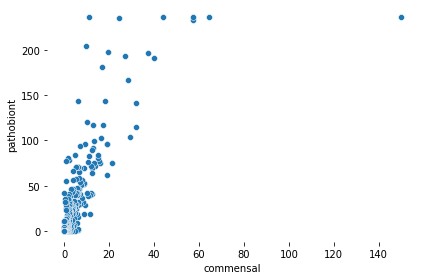

In [ ]:
sns.scatterplot(x = 'commensal', y = 'pathobiont', data = comb_df2)
sns.despine(bottom = True, left = True)
plt.tight_layout()